In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import calendar
#import prophet
from datetime import datetime

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

plt.rcParams["figure.figsize"] = (10,8)

In [2]:
df = pd.read_csv("data/bikes.csv", index_col = 0 )

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(2)
memory usage: 97.0+ KB


In [4]:
df.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
521,522,06-06-2019,summer,1,6,0,3,1,1,22.720847,27.11460,61.1250,5.167375,1027,6028,7055
407,408,12-02-2019,spring,1,2,0,0,0,1,5.227500,5.08290,46.4583,27.417204,73,1456,1529
682,683,14-11-2019,winter,1,11,0,3,1,1,11.855847,14.07815,55.2083,13.374875,373,5122,5495
49,50,19-02-2018,spring,0,2,0,6,0,1,16.365847,19.57020,18.7917,34.000021,532,1103,1635
168,169,18-06-2018,summer,0,6,0,6,0,1,28.563347,32.19770,67.0417,8.000336,1807,3312,5119


- 1. En la columna yr, el 0 hace referencia a 2018 y el 1 2019 ---> cambiar a 2018 y 2019
- 2. Revisar estaciones segun meses - DONE  - día específico de la semana 😒
- 3. Los dias de la semana pasarlos a str (texto)
- 4. Redondear temperaturas
- 5. Cambiar dteday a tipo daytime DONE 
- 6. Comprobar festivos - columna holiday - 16 días
- 7. Los dias de la semana no corresponden con los que debieran ser 🤦‍♀️🤦‍♀️
- 8. librería prophet - solo festivos nacionales 👁️ hacer otro entorno
- 9. Librería calendar - dia de la semana DONE.
- 10. Chequear funcion seasons 

Weathersit :
- 1: Sol y nubes
- 2: Niebla - nublado
- 3: Regulinchi
- 4: Tiempo chungo

In [5]:
df.duplicated().sum()

0

In [6]:
df.shape

(730, 16)

__________
Reasignamos columna season

In [7]:
#Cambiar columna 'dteday' a datatime

df.dteday =pd.to_datetime(df.dteday, dayfirst=True)

In [8]:
primavera = df[df['season']=='spring'] #Primavera 20 marzo - 21 junio
primavera['mnth'].unique()

array([ 1,  2,  3, 12])

In [9]:
invierno = df[df['season']=='winter'] # Invierno 21 de diciembre - 20 de marzo
invierno['mnth'].unique()

array([ 9, 10, 11, 12])

In [10]:
#Verano 21 junio - 23 septiembre 
verano = df[df['season']=='summer'] 
verano['mnth'].unique()

array([3, 4, 5, 6])

In [11]:
#Otoño 23 septiembre - 21 de diciembre
otoño = df[df['season']=='autumn'] 
otoño['mnth'].unique()

array([6, 7, 8, 9])

In [12]:
mapa_estaciones ={"spring": "winter", "winter": "autumn", "summer":"spring", "autumn":"summer"}

In [13]:
df["season"] = df["season"].map(mapa_estaciones)

In [14]:
#Primavera 21 marzo - 20 junio
#Verano 21 junio - 22 septiembre 
#Otoño 23 septiembre - 20 de diciembre
#Invierno 21 de diciembre - 20 de marzo

_________________

Ajustamos los días de la semana

In [15]:
def dia_semana(col):
    return col.isoweekday()

In [16]:
df["weekday"]= df["dteday"].apply(dia_semana)

__________


In [17]:
df.workingday.value_counts()

1    499
0    231
Name: workingday, dtype: int64

In [18]:
df.holiday.value_counts()

0    709
1     21
Name: holiday, dtype: int64

In [19]:
#festivos = df[df['holiday']== 1]

In [39]:
festivos_18 = ["2018-01-01","2018-01-16", "2018-02-13", "2018-02-20", "2018-03-31", "2018-05-29", "2018-07-04", "2018-07-05", "2018-07-28" , "2018-09-04", "2018-10-23", "2018-10-24", "2018-12-24", "2018-12-25", "2018-12-31"]
festivos_19 = ["2019-01-01","2019-01-16", "2019-02-13", "2019-02-20", "2019-03-31", "2019-05-29", "2019-07-04", "2019-07-05", "2019-07-28" , "2019-09-04", "2019-10-23", "2019-10-24", "2019-12-24", "2019-12-25", "2019-12-31"]

In [217]:
df["holiday"] = df["dteday"].isin(["2018-01-01","2018-01-16", "2018-02-13", "2018-02-20", "2018-03-31", "2018-05-29", "2018-07-04", "2018-07-05", "2018-07-28" , "2018-09-04", "2018-10-23", "2018-10-24", "2018-12-24", "2018-12-25", "2018-12-31","2019-01-01","2019-01-16", "2019-02-13", "2019-02-20", "2019-03-31", "2019-05-29", "2019-07-04", "2019-07-05", "2019-07-28" , "2019-09-04", "2019-10-23", "2019-10-24", "2019-12-24", "2019-12-25", "2019-12-31"])
df.sample(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
220,221,2018-08-09,summer,0,8,False,4,1,1,31.775000,36.20605,57.0417,10.125107,907,3695,4602
729,730,2019-12-31,winter,1,12,True,2,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729
258,259,2018-09-16,summer,0,9,False,7,1,2,19.235847,23.07375,59.0417,11.000261,742,4018,4760


In [218]:
df.loc[df['holiday'] == False, 'holiday'] = 0
df.loc[df['holiday'] == True, 'holiday'] = 1


In [136]:
df.sample(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
138,139,2018-05-19,spring,0,5,0,6,1,2,21.764153,25.5371,82.9583,7.250271,735,3840,4575
144,145,2018-05-25,spring,0,5,0,5,1,1,27.094153,30.7771,69.6250,10.333611,740,4238,4978
722,723,2019-12-24,winter,1,12,1,2,1,2,9.483464,12.9450,79.1304,5.174437,174,746,920


In [137]:
df.holiday.unique()

array([1, 0], dtype=object)

In [26]:
#Sacamos ls festivos con la libreria 
from datetime import date
import holidays
  
us_holidays = holidays.US()
festivos_nuevo = []
for i in holidays.US(years = [2018, 2019], state = 'WA').items():
    festivos_nuevo.append(i)



In [27]:
#Creamos una lista con los festivos que faltan de la lista proporcionada por la empresa 
festivos_añadir = ['2018-02-13', '2018-03-31', '2018-07-05', '2018-07-28', '2018-11-24', '2018-12-24','2018-12-31', '2019-11-29', '2019-02-13' , '2019-03-31', '2019-07-05'
,'2019-07-28' , '2019-12-24' , '2019-12-31']

In [28]:
#Apendeamos la lista
in_holidays = holidays.HolidayBase()
in_holidays.append(festivos_añadir)

  

In [29]:
#Convertimos a diccionario para poder añadirlo a las vacaciones que teniamos 
dict_holidays = dict(festivos_nuevo)

In [30]:
in_holidays.update(dict_holidays)

In [31]:
in_holidays.keys()


dict_keys([datetime.date(2018, 2, 13), datetime.date(2018, 3, 31), datetime.date(2018, 7, 5), datetime.date(2018, 7, 28), datetime.date(2018, 11, 24), datetime.date(2018, 12, 24), datetime.date(2018, 12, 31), datetime.date(2019, 11, 29), datetime.date(2019, 2, 13), datetime.date(2019, 3, 31), datetime.date(2019, 7, 5), datetime.date(2019, 7, 28), datetime.date(2019, 12, 24), datetime.date(2019, 12, 31), datetime.date(2018, 1, 1), datetime.date(2018, 1, 15), datetime.date(2018, 2, 19), datetime.date(2018, 5, 28), datetime.date(2018, 7, 4), datetime.date(2018, 9, 3), datetime.date(2018, 10, 8), datetime.date(2018, 11, 11), datetime.date(2018, 11, 12), datetime.date(2018, 11, 22), datetime.date(2018, 12, 25), datetime.date(2019, 1, 1), datetime.date(2019, 1, 21), datetime.date(2019, 2, 18), datetime.date(2019, 5, 27), datetime.date(2019, 7, 4), datetime.date(2019, 9, 2), datetime.date(2019, 10, 14), datetime.date(2019, 11, 11), datetime.date(2019, 11, 28), datetime.date(2019, 12, 25)])

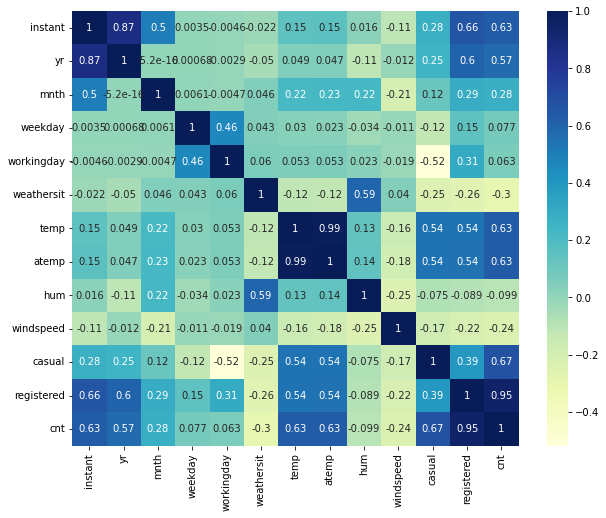

In [32]:
sns.heatmap(df.corr(), 
            cmap = "YlGnBu", 
           annot = True);

In [33]:
df.tail(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
720,721,2019-12-22,winter,1,12,0,7,0,1,10.899153,11.80565,44.1250,27.292182,205,1544,1749
721,722,2019-12-23,winter,1,12,0,1,0,1,10.079153,12.97355,51.5417,8.916561,408,1379,1787
722,723,2019-12-24,winter,1,12,1,2,1,2,9.483464,12.94500,79.1304,5.174437,174,746,920
723,724,2019-12-25,winter,1,12,1,3,0,2,11.943464,14.72325,73.4783,11.304642,440,573,1013
724,725,2019-12-26,winter,1,12,0,4,1,3,9.976653,11.01665,82.3333,21.208582,9,432,441
725,726,2019-12-27,winter,1,12,0,5,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,2019-12-28,winter,1,12,0,6,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,2019-12-29,winter,1,12,0,7,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,2019-12-30,winter,1,12,0,1,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796
729,730,2019-12-31,winter,1,12,1,2,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    object        
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    object        
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [35]:
df.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
31,32,2018-02-01,winter,0,2,0,4,1,2,7.879134,11.72650,82.9565,3.565271,47,1313,1360
277,278,2018-10-05,autumn,0,10,0,5,1,1,22.071653,26.35690,64.7917,11.875750,559,4267,4826
633,634,2019-09-26,autumn,1,9,0,4,1,1,26.035000,29.83065,63.0833,16.374800,787,6946,7733
261,262,2018-09-19,summer,0,9,0,3,1,2,22.515847,26.48375,69.0000,10.166714,691,3848,4539
437,438,2019-03-14,winter,1,3,0,4,1,1,23.472500,27.43085,50.7083,7.709154,997,5315,6312


In [36]:
# Identificar los dias exactos por season 
festivos =[]

